In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import contours

In [2]:
def show(img):
    plt.imshow(img)

In [42]:
img = cv2.imread('s4.jpeg')

In [56]:
img_org = cv2.imread('s4.jpeg')

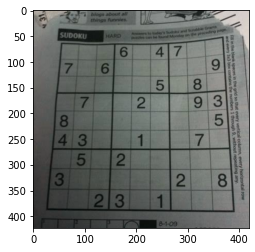

In [44]:
show(img)

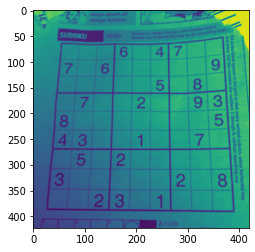

In [45]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
show(gray)

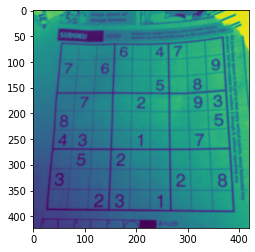

In [46]:
blur = cv2.GaussianBlur(gray, (5, 5), 1)
show(blur)

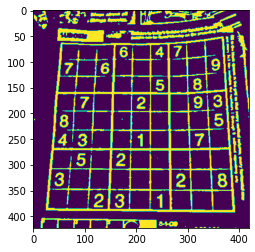

In [47]:
thres = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)
show(thres)

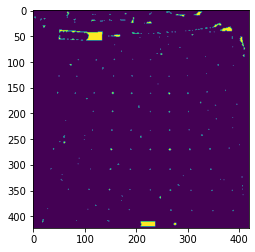

In [48]:
cnts,_ = cv2.findContours(thres.astype(np.uint8).copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cntimg = cv2.drawContours(thres, cnts, -1, (0, 255, 0), 3)
show(cntimg)

In [49]:
outer_box = np.array([])
max_area = 0
for i in cnts:
    area = cv2.contourArea(i)
    if area > 25:
        peri = cv2.arcLength(i, True)
        approx = cv2.approxPolyDP(i, 0.02*peri, True)
        if area > max_area and len(approx) == 4:
            outer_box = approx
            max_area = area

In [50]:
cv2.drawContours(img_org, outer_box, -1, (0, 0), 15)
pts1 = np.float32(outer_box)
pts2 = np.float32([[0, 0], [450, 0], [0, 450], [450, 450]])
matrix = cv2.getPerspectiveTransform(pts1, pts2)
img_wrap_colored = cv2.warpPerspective(img_org, matrix, (450, 450))
img_wrap_colored = cv2.cvtColor(img_wrap_colored, cv2.COLOR_BGR2GRAY)

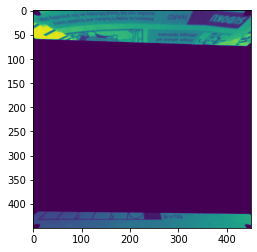

In [52]:
show(img_wrap_colored)

In [54]:
x1,y1 = outer_box[0][0]
x2,y2 = outer_box[1][0]
x3,y3 = outer_box[2][0]
x4,y4 = outer_box[3][0]
top_left_x = min([x1,x2,x3,x4])
top_left_y = min([y1,y2,y3,y4])
bot_right_x = max([x1,x2,x3,x4])
bot_right_y = max([y1,y2,y3,y4])

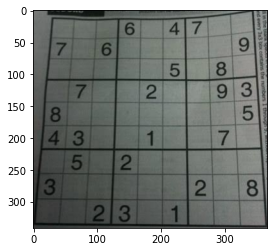

In [57]:
img_org = img_org[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1].copy()
show(img_org)

In [60]:
for c in cnts:
    area = cv2.contourArea(c)
    if area < 1000:
        cv2.drawContours(thres, [c], -1, (0,0,0), -1)

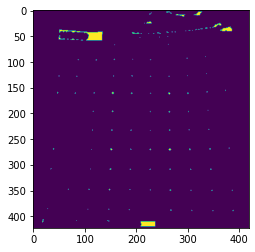

In [62]:
show(thres)

In [63]:
# Fix horizontal and vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
img = cv2.morphologyEx(thres, cv2.MORPH_CLOSE, vertical_kernel, iterations=9)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
img = cv2.morphologyEx(thres, cv2.MORPH_CLOSE, horizontal_kernel, iterations=4)

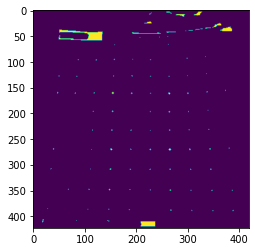

In [64]:
show(img)

In [65]:
# Sort by top to bottom and each row by left to right
invert = 255 - img
cnts,_ = cv2.findContours(invert, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cnts, _ = contours.sort_contours(cnts, method="top-to-bottom")

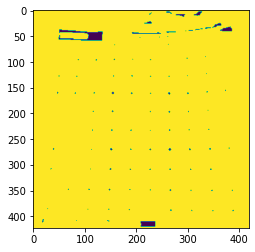

In [66]:
show(invert)

In [67]:
sudoku_rows = []
row = []
for (i, c) in enumerate(cnts, 1):
    area = cv2.contourArea(c)
    if area < 50000:
        row.append(c)
        if i % 9 == 0:  
            (cnts, _) = contours.sort_contours(row, method="left-to-right")
            sudoku_rows.append(cnts)
            row = []

In [68]:
# for row in sudoku_rows:
    for c in row:
        mask = np.zeros(img.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        result = cv2.bitwise_and(img, mask)
        result[mask==0] = 255
        cv2.imshow('result', result)
        cv2.waitKey(1000)